
#### 웹크롤링 부분

In [1]:
!pip install selenium webdriver_manager
!pip install matplotlib pillow

!wget -q -O - https://dl-ssl.google.com/linux/linux_signing_key.pub | sudo apt-key add -
!echo "deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main" | sudo tee /etc/apt/sources.list.d/google-chrome.list
!apt-get update
!apt-get install -y google-chrome-stable

import pandas as pd
import numpy as np
import time
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# mecab 설치 코드
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd 'Mecab-ko-for-Google-Colab'
!bash install_mecab-ko_on_colab_light_220429.sh


# Okt, Mecab 객체 생성
from konlpy.tag import Okt, Mecab
okt = Okt()
mecab = Mecab()


# 한글 폰트 설치 코드
!apt-get update -qq
!apt-get install fonts-nanum* -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 12.0 MB/s eta 0:00:00
OK
deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main
Get:1 http://dl.google.com/linux/chrome/deb stable InRelease [1,825 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1,210 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
H

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 7.14 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 31.4 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-03-28 04:26:00--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.135, 13.200.41.136, 13.200.41.134, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.135|:443... connected.
HTTP request sent, await

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # 백그라운드 실행
options.add_argument('--no-sandbox')  # 권한 문제 방지
options.add_argument('--disable-dev-shm-usage')  # /dev/shm 공간 부족 문제 해결
options.binary_location = "/usr/bin/google-chrome"  # Chrome 설치 경로 명시

# ChromeDriver 실행, 크롤링할 메인 페이지를 load함.
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)


url = 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000208023&t_page=%ED%86%B5%ED%95%A9%EA%B2%80%EC%83%89%EA%B2%B0%EA%B3%BC%ED%8E%98%EC%9D%B4%EC%A7%80&t_click=%EA%B2%80%EC%83%89%EC%83%81%ED%92%88%EC%83%81%EC%84%B8&t_search_name=%EB%82%AB%ED%8F%AC%EC%9C%A0&t_number=13&dispCatNo=1000001000300150003,1000001000700110007&trackingCd=Result_11_30'
# url = 'https://brand.naver.com/lush/products/5290384034?nl-query=%ED%97%A4%EC%96%B4%EB%AF%B8%EC%8A%A4%ED%8A%B8&nl-au=46c0ee630230457ab452c131feec29e2&NaPm=ci%3D46c0ee630230457ab452c131feec29e2%7Cct%3Dm8mp5k88%7Ctr%3Dnslsl%7Csn%3D339543%7Chk%3Db9c251ce2e6e56575fc74ac088eacec94c5a4d02'
driver.get(url)

# 테스트.
print(url)

In [ ]:
review_tab = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, "reviewInfo")))
review_tab.click()

WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "#reviewInfo.on")))

latest_sort_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#gdasSort > li:nth-child(3)")))

latest_sort_button.click()

WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "#gdasSort > li.on")))

In [ ]:
driver.execute_script("goods.gdas.filter.getFilter()")
WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#searchPoint")))

In [ ]:
# DataFrame 생성 (리뷰와 날짜를 함께 저장)
df_review_cos1 = pd.DataFrame(columns=['review_text', 'review_date', 'review_rate', 'review_moisture', 'review_sticky', 'review_scent'])


# # 리뷰 크롤링 함수 정의 (페이지 수를 설정하지 않고 자동 종료)
# def review_crawling(driver, df):
#     current_page = 1  # 현재 페이지를 1로 초기화
#     while True:
#         # 리뷰의 인덱스는 한 페이지 내에서 1~10까지 존재
#         for i in range(1, 11):  # 한 페이지 내 10개 리뷰 크롤링
#             try:
#                 # 리뷰 텍스트 크롤링
#                 txt = driver.find_element(By.CSS_SELECTOR, f'#gdasList > li:nth-child({i}) > div.review_cont > div.txt_inner').text

#                 # 리뷰 날짜 크롤링
#                 date = driver.find_element(By.CSS_SELECTOR, f'#gdasList > li:nth-child({i}) > div.review_cont > div.score_area > span.date').text

#                 # DataFrame에 리뷰 텍스트와 날짜 추가
#                 df.loc[len(df)] = [txt, date]

#             except Exception as e:
#                 print(f"리뷰 크롤링 중 오류 발생 (페이지 {current_page}, 리뷰 {i}): {e}")
#                 pass

#         try:
#             # 페이지 넘기기 로직
#             if current_page % 10 == 0:  # 현재 페이지가 10의 배수일 때 (10, 20, 30...)
#                 next_button = driver.find_element(By.CSS_SELECTOR, '#gdasContentsArea > div > div.pageing > a.next')
#                 next_button.click()
#                 time.sleep(2)  # 페이지 로드 대기

#             elif current_page < 10:  # 1자리 수 페이지일 때 (1~9페이지)
#                 # 현재 페이지가 1~9일 때는 nth-child(current_page + 1)
#                 next_button = driver.find_element(By.CSS_SELECTOR, f'#gdasContentsArea > div > div.pageing > a:nth-child({current_page + 1})')
#                 next_button.click()
#                 time.sleep(2)  # 페이지 로드 대기

#             else:  # 2자리 수 페이지일 때 (11페이지 이상)
#                 # 페이지가 2자리 수일 때는 nth-child(2)부터 시작하여 3, 4, 5 등으로 이동
#                 next_button = driver.find_element(By.CSS_SELECTOR, f'#gdasContentsArea > div > div.pageing > a:nth-child({(current_page % 10) + 2})')
#                 next_button.click()
#                 time.sleep(2)  # 페이지 로드 대기


#             current_page += 1  # 페이지 카운트 증가

#         except Exception as e:
#             print(f"페이지 넘기기 중 오류 발생 (페이지 {current_page}): {e}")
#             break  # 더 이상 페이지를 넘길 수 없으면 반복문 종료

#         print(f'{current_page} 페이지 크롤링 완료')

def review_crawling(driver, df):
    current_page = 1  # 현재 페이지를 1로 초기화
    while True:
        # 리뷰의 인덱스는 한 페이지 내에서 1~10까지 존재
        for i in range(1, 11):  # 한 페이지 내 10개 리뷰 크롤링
            try:
                # 리뷰 텍스트 크롤링
                txt = driver.find_element(By.CSS_SELECTOR, f'#gdasList > li:nth-child({i}) > div.review_cont > div.txt_inner').text

                # 리뷰 날짜 크롤링
                date = driver.find_element(By.CSS_SELECTOR, f'#gdasList > li:nth-child({i}) > div.review_cont > div.score_area > span.date').text

                # 리뷰 평점 크롤링
                rate = driver.find_element(By.CSS_SELECTOR, f'#gdasList > li:nth-child({i}) > div.review_cont > div.score_area > span.review_point > span.point').text

                # 보습력 평점 크롤링
                moisture = driver.find_element(By.CSS_SELECTOR, f'#gdasList > li:nth-child({i}) > div.review_cont > div.poll_sample > dl.poll_type1 > dd > span.txt').text

                # 끈적임 평점 크롤링
                sticky = driver.find_element(By.CSS_SELECTOR, f'#gdasList > li:nth-child({i}) > div.review_cont > div.poll_sample > dl.poll_type1:nth-of-type(2) > dd > span.txt').text

                # 향 평점 크롤링
                scent = driver.find_element(By.CSS_SELECTOR, f'#gdasList > li:nth-child({i}) > div.review_cont > div.poll_sample > dl.poll_type1:nth-of-type(3) > dd > span.txt').text

                # DataFrame에 리뷰 텍스트와 날짜 추가
                df.loc[len(df)] = [txt, date, rate, moisture, sticky, scent]

            except Exception as e:
                print(f"리뷰 크롤링 중 오류 발생 (페이지 {current_page}, 리뷰 {i}): {e}")
                pass

        try:
            # 다음 페이지 버튼 찾기
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, f'a[data-page-no="{current_page + 1}"]'))
            )
            driver.execute_script("arguments[0].click();", next_button)
            current_page += 1  # 페이지 카운트 증가
            time.sleep(2)  # 페이지 로드 대기

        except Exception as e:
            print(f"페이지 넘기기 중 오류 발생 (페이지 {current_page}): {e}")
            break  # 더 이상 페이지를 넘길 수 없으면 반복문 종료

        print(f'{current_page} 페이지 크롤링 완료')

# # 크롤링 함수 호출
# review_crawling(driver, df_review_cos1)

# # 크롤링 결과 출력
# df_review_cos1.head()

In [ ]:
# 크롤링 함수 호출
review_crawling(driver, df_review_cos1)

# 크롤링 결과 출력
df_review_cos1.head()

In [ ]:
df_review_cos1

In [ ]:
# 허용되지 않는 문자를 제거하는 함수
def remove_illegal_characters(df):
    # 모든 문자열 데이터에서 허용되지 않는 문자 (예: null 문자) 제거
    df = df.replace(r'[\x00-\x1F]+', '', regex=True)
    return df


df_review_cos1_clean = remove_illegal_characters(df_review_cos1)


df_review_cos1_clean.to_csv("oliveyoung_reviews.csv", index=False)

In [ ]:
from google.colab import files
files.download("oliveyoung_reviews.csv")

#### 기존 방식

In [7]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

# 내 드라이브의 경로 확인
my_drive_path = '/content/drive/My Drive/'
print("내 드라이브 경로:", my_drive_path)

# 내 드라이브의 파일 목록 확인
print("내 드라이브의 파일 목록:")
print(os.listdir(my_drive_path))

내 드라이브 경로: /content/drive/My Drive/
내 드라이브의 파일 목록:
['Colab Notebooks', '달리프_oliveyoung_reviews.csv', '실크테라피_oliveyoung_reviews.csv', '어노브_oliveyoung_reviews.csv', 'stopwords-ko.txt', '연관키워드 20250326 1501.csv', 'hair_mist_DS', '웹크롤링_리뷰분석.ipynb']


In [12]:
cd /drive/MyDrive/

/content/drive


In [15]:
ls

'Colab Notebooks'/   달리프_oliveyoung_reviews.csv      '연관키워드 20250326 1501.csv'
 hair_mist_DS/       실크테라피_oliveyoung_reviews.csv   웹크롤링_리뷰분석.ipynb
 stopwords-ko.txt    어노브_oliveyoung_reviews.csv


In [16]:
df = pd.read_csv('./실크테라피_oliveyoung_reviews.csv', encoding='utf-8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      1000 non-null   object
 1   review_date      1000 non-null   object
 2   review_rate      1000 non-null   object
 3   review_moisture  1000 non-null   object
 4   review_sticky    1000 non-null   object
 5   review_scent     1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [17]:
df = df.rename(columns={'review_text': 'text', 'review_date': 'date', 'review_rate': 'rate'})

# rate에서 점수 추출 (split 활용)
df['rate'] = df['rate'].apply(lambda x: int(x.split(' ')[1][0]))

In [18]:
df.head()

,text,date,rate,review_moisture,review_sticky,review_scent
0,향기가 좋아서 기분도 좋아져요.머리가 푸석할때 뿌려주니 좋네요.,2025.03.21,5,부드러워요,아주 만족해요,가벼워요
1,진짜 뿌리자마자 부드러워져요...대박 향도 좋아서 자주씁니다,2025.03.20,5,부드러워요,아주 만족해요,되직해요
2,무난하게 사용하기 좋아요 늘 쓰는 제품인데 만족합니다 ~~,2025.03.20,5,부드러워요,아주 만족해요,되직해요
3,꾸준템 입니다.본인 가는 모발에 잘 푸석이는 모발인데 이거 쓰면 떡져보이지도 않고 ...,2025.03.18,5,부드러워요,아주 만족해요,가벼워요
4,아무래도 이걸로 푸석함을 없애주기엔 어렵겠죵 .. 그냥 뿌린듯 만듯 한 거 같아용 ...,2025.03.17,4,푸석여요,보통이에요,가벼워요


In [19]:
# 성분/피부 타입 변경 시 df 컬럼명 수정할 것!

# 열 이름 변경
# moisture_score(보습), sticky(끈적임), scent(향), cleansing(세정력), stimulation(자극도), hair_texture(머릿결)등을 고려해서 변경
df = df.rename(columns={'review_moisture': 'hair_texture', 'review_sticky': 'scent', 'review_scent': 'texture'})
df.head()

,text,date,rate,hair_texture,scent,texture
0,향기가 좋아서 기분도 좋아져요.머리가 푸석할때 뿌려주니 좋네요.,2025.03.21,5,부드러워요,아주 만족해요,가벼워요
1,진짜 뿌리자마자 부드러워져요...대박 향도 좋아서 자주씁니다,2025.03.20,5,부드러워요,아주 만족해요,되직해요
2,무난하게 사용하기 좋아요 늘 쓰는 제품인데 만족합니다 ~~,2025.03.20,5,부드러워요,아주 만족해요,되직해요
3,꾸준템 입니다.본인 가는 모발에 잘 푸석이는 모발인데 이거 쓰면 떡져보이지도 않고 ...,2025.03.18,5,부드러워요,아주 만족해요,가벼워요
4,아무래도 이걸로 푸석함을 없애주기엔 어렵겠죵 .. 그냥 뿌린듯 만듯 한 거 같아용 ...,2025.03.17,4,푸석여요,보통이에요,가벼워요


In [20]:
# 컬럼명에 따라서 주석 처리 및 주석 해제

# moisture(보습) 열 값에 따라 점수 매기기
# df['moisture_score'] = df['moisture'].apply(lambda x: 3 if x == '보습이 뛰어나요' else (2 if x == '보통이에요' else 1))

# sticky(끈적임) 열 값에 따라 점수 매기기
# df['sticky_score'] = df['sticky'].apply(lambda x: 3 if x == '끈적임이 없어요' else (2 if x == '보통이에요' else 1))

# scent(향) 열 값에 따라 점수 매기기
df['scent_score'] = df['scent'].apply(lambda x: 3 if x == '아주 만족해요' else (2 if x == '보통이에요' else 1))

# cleansing(세정력) 열 값에 따라 점수 매기기
# df['cleansing_score'] = df['cleansing'].apply(lambda x: 3 if x == '아주 만족해요' else (2 if x == '보통이에요' else 1))

# stimulation(자극도) 열 값에 따라 점수 매기기
# df['stimulation_score'] = df['stimulation'].apply(lambda x: 3 if x == '자극없이 순해요' else (2 if x == '보통이에요' else 1))

# hair_texture(머릿결) 열 값에 따라 점수 매기기
df['hair_texture_score'] = df['hair_texture'].apply(lambda x: 3 if x == '부드러워요' else (2 if x == '보통이에요' else 1))

# 결과 출력
df.head()

,text,date,rate,hair_texture,scent,texture,scent_score,hair_texture_score
0,향기가 좋아서 기분도 좋아져요.머리가 푸석할때 뿌려주니 좋네요.,2025.03.21,5,부드러워요,아주 만족해요,가벼워요,3,3
1,진짜 뿌리자마자 부드러워져요...대박 향도 좋아서 자주씁니다,2025.03.20,5,부드러워요,아주 만족해요,되직해요,3,3
2,무난하게 사용하기 좋아요 늘 쓰는 제품인데 만족합니다 ~~,2025.03.20,5,부드러워요,아주 만족해요,되직해요,3,3
3,꾸준템 입니다.본인 가는 모발에 잘 푸석이는 모발인데 이거 쓰면 떡져보이지도 않고 ...,2025.03.18,5,부드러워요,아주 만족해요,가벼워요,3,3
4,아무래도 이걸로 푸석함을 없애주기엔 어렵겠죵 .. 그냥 뿌린듯 만듯 한 거 같아용 ...,2025.03.17,4,푸석여요,보통이에요,가벼워요,2,1


In [21]:
def preprocess(data):
  my_split = []
  for pas in data.iloc:
    data = (pas['text'])
    split_data = re.sub('[^가-힣]', ' ', data).split(' ')
    for i in split_data:
      if len(i) >= 2:
        my_split.append(i)
  return my_split

product_review = preprocess(df)
product_review

['향기가',
 '좋아서',
 '기분도',
 '좋아져요',
 '머리가',
 '푸석할때',
 '뿌려주니',
 '좋네요',
 '진짜',
 '뿌리자마자',
 '부드러워져요',
 '대박',
 '향도',
 '좋아서',
 '자주씁니다',
 '무난하게',
 '사용하기',
 '좋아요',
 '쓰는',
 '제품인데',
 '만족합니다',
 '꾸준템',
 '입니다',
 '본인',
 '가는',
 '모발에',
 '푸석이는',
 '모발인데',
 '이거',
 '쓰면',
 '떡져보이지도',
 '않고',
 '좋음',
 '향도',
 '좋아서',
 '이거',
 '뿌리면',
 '기분',
 '좋아짐',
 '아무래도',
 '이걸로',
 '푸석함을',
 '없애주기엔',
 '어렵겠죵',
 '그냥',
 '뿌린듯',
 '만듯',
 '같아용',
 '뿌린',
 '거보단',
 '나은듯한',
 '기름지는거없이',
 '정말',
 '수분만',
 '채워주는제품이라',
 '너무',
 '애정하는',
 '제품입니다',
 '품절이자주뜨는데',
 '재구매의사',
 '완전',
 '뿜뿜합니다',
 '아니',
 '이거',
 '요물임',
 '진짜',
 '오일용도',
 '좋지만',
 '스프레이용',
 '미챳음저',
 '미쟝센',
 '쓰다가',
 '너무',
 '떡져서',
 '이걸러',
 '갈아',
 '탓네요',
 '이거',
 '진짜',
 '대충',
 '와다다',
 '뿌려더',
 '안지고머리결이',
 '그냥',
 '녹아내리듯이',
 '사라락',
 '빗기고',
 '말로',
 '표현',
 '못한',
 '진짜',
 '믿고',
 '써봐야',
 '좋음',
 '근데',
 '향도',
 '좋다',
 '말모',
 '굿굿',
 '가볍고',
 '실리콘',
 '없어서',
 '구매했어요차분히',
 '정리되고',
 '머릿결에',
 '도움됨',
 '가벼운제형의',
 '제품이에요',
 '향은',
 '살짝',
 '별루지만',
 '제형이',
 '가벼워서',
 '좋아용',
 '떡짐이아예없어용',
 '이거',
 '진짜',
 '좋은데',
 '너무',
 '빨리써요',
 '비싸서'

In [22]:
all_reviews = ' '.join(product_review)
pos = mecab.pos(all_reviews[:1000000000])

print(pos[:1000])

[('향기', 'NNG'), ('가', 'JKS'), ('좋', 'VA'), ('아서', 'EC'), ('기분', 'NNG'), ('도', 'JX'), ('좋', 'VA'), ('아', 'EC'), ('져요', 'VX+EF'), ('머리', 'NNG'), ('가', 'JKS'), ('푸석', 'MAG'), ('할', 'VV+ETM'), ('때', 'NNG'), ('뿌려', 'VV+EC'), ('주', 'VX'), ('니', 'EC'), ('좋', 'VA'), ('네요', 'EF'), ('진짜', 'MAG'), ('뿌리', 'VV'), ('자마자', 'EC'), ('부드러워져', 'VA+EC+VX+EC'), ('요', 'MM'), ('대박', 'NNG'), ('향', 'NNG'), ('도', 'JX'), ('좋', 'VA'), ('아서', 'EC'), ('자주', 'MAG'), ('씁니다', 'VV+EC'), ('무난', 'XR'), ('하', 'XSA'), ('게', 'EC'), ('사용', 'NNG'), ('하', 'XSV'), ('기', 'ETN'), ('좋', 'VA'), ('아요', 'EC'), ('쓰', 'VV'), ('는', 'ETM'), ('제품', 'NNG'), ('인데', 'VCP+EC'), ('만족', 'NNG'), ('합니다', 'XSV+EF'), ('꾸준', 'XR'), ('템', 'NNG'), ('입니다', 'VCP+EF'), ('본인', 'NNG'), ('가', 'VV'), ('는', 'ETM'), ('모발', 'NNG'), ('에', 'JKB'), ('푸석이', 'NNG'), ('는', 'JX'), ('모발', 'NNG'), ('인데', 'VCP+EC'), ('이거', 'NP'), ('쓰', 'VV'), ('면', 'EC'), ('떡', 'NNG'), ('져', 'XSV+EF'), ('보이', 'VV'), ('지', 'EC'), ('도', 'JX'), ('않', 'VX'), ('고', 'EC'), ('좋', 'VA'), ('음', '

In [23]:
# 명사 형용사 동사만 뽑아내기.

morphs = []


# 명사, 동사 추출해내기
for data in pos:
    if 'NNG' in data:
        # if len(data[0]) >= 2 and data[0] != '드름':
        if data[0] != '드름':
            morphs.append(data[0])

print(morphs)

['향기', '기분', '머리', '때', '대박', '향', '사용', '제품', '만족', '템', '본인', '모발', '푸석이', '모발', '떡', '향', '기분', '수분', '제품', '애정', '제품', '품절', '구매', '의사', '요물', '오일', '스프레이', '미', '미', '센', '머리', '결', '사라', '말', '표현', '향', '굿', '굿', '실리콘', '구매', '정리', '머릿결', '도움', '제형', '제품', '향', '별루', '제형', '떡', '짐', '구매', '고민', '제품', '노브', '사용', '사용', '회복', '유지', '홈', '쇼핑', '영', '사용', '트', '구매', '추천', '당', '센스', '사용', '손', '미스트', '제품', '구매', '제품', '맘', '머릿결', '도움', '리필', '대용량', '제형', '향도', '흡수', '머릿결', '개선', '도움', '힐링', '세일', '구매', '정도', '정도', '정도', '실크', '테라', '피', '조음', '사용', '향도', '마음', '제품', '손상', '머리', '관리', '드라이', '전', '머리', '효과', '로션', '머리', '떡', '때', '날', '남자', '친구', '냄새', '가까이', '용', '제품', '상황', '재고', '근처', '픽업', '주문', '존재', '제품', '상황', '재고', '근처', '픽업', '주문', '존재', '향', '워터', '타입', '사용', '머릿결', '구매', '템', '강추', '향도', '머릿결', '추억', '실크', '테', '블로그', '유행', '실크', '테라', '피', '무조건', '잇', '뷰티', '어른', '필요', '향', '거부', '머리', '코팅', '느낌', '만족', '해용', '저녁', '머리', '헤어', '관리', '사용', '사용', '전', '머릿결', '관리', '점', '머리',

In [24]:
counts = Counter(morphs)

print(counts)

Counter({'머리': 370, '사용': 314, '향': 290, '구매': 227, '제품': 218, '머릿결': 186, '실크': 146, '테라': 133, '미스트': 121, '헤어': 116, '피': 110, '때': 106, '만족': 87, '느낌': 77, '제형': 74, '향도': 74, '손': 73, '트': 64, '전': 63, '추천': 62, '효과': 62, '결': 57, '머리카락': 54, '세일': 53, '에센스': 51, '센스': 50, '향기': 48, '냄새': 45, '오일': 43, '드라이': 43, '모발': 42, '분사': 42, '떡': 41, '스프레이': 39, '정도': 38, '건조': 35, '가격': 34, '타입': 30, '아침': 30, '후': 30, '생각': 29, '정전기': 28, '템': 27, '맘': 26, '관리': 26, '최고': 25, '굿': 24, '의사': 22, '요향': 22, '손상': 21, '마음': 20, '올리브': 20, '짐': 19, '흡수': 19, '용량': 19, '배송': 19, '사력': 19, '기분': 18, '친구': 18, '빗질': 18, '상품': 18, '수분': 17, '날': 17, '할인': 17, '겨울': 17, '정리': 16, '미용실': 16, '부담': 16, '브랜드': 16, '처음': 15, '양': 15, '말': 14, '영': 14, '점': 14, '사람': 14, '윤기': 14, '도움': 13, '감사': 13, '시간': 13, '후기': 13, '개선': 12, '강추': 12, '다음': 12, '엄마': 12, '향수': 12, '물': 12, '상태': 12, '두피': 12, '필요': 11, '용도': 11, '이용': 11, '방지': 11, '형태': 11, '끈': 11, '컬': 11, '대신': 11, '부족': 11, '주문': 10, '마무리': 1

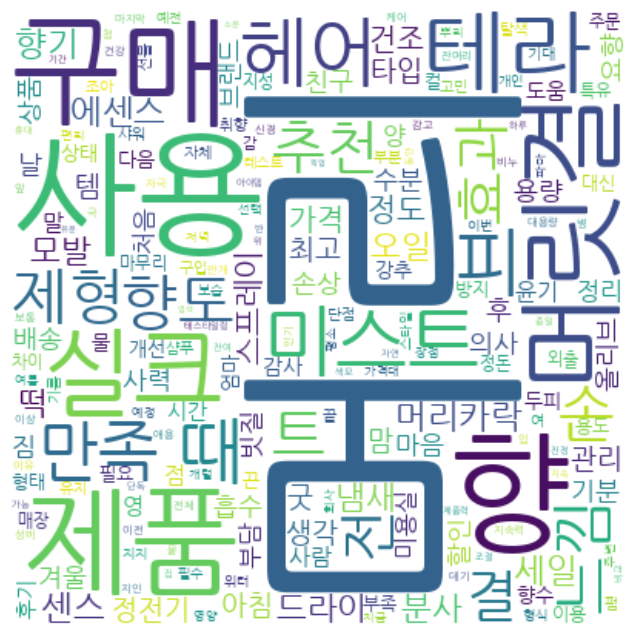

In [26]:
wordcloud = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    width=400,
    height=400,
    background_color='white'
).generate_from_frequencies(counts)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
from sklearn.feature_extraction.text import CountVectorizer


# 불용어 리스트
korean_stopwords = [
    "이", "그", "저", "것", "이것", "저것", "는", "은", "이", "가", "을", "를",
    "에", "의", "도", "와", "과", "의", "있", "없", "다", "만", "한", "되", "처럼",
    "입니다", "세요", "나", "보다", "다시", "있어요", "없어요"
]

# CountVectorizer 사용하여 2-gram과 3-gram 추출
vectorizer = CountVectorizer(ngram_range=(3,3), stop_words=korean_stopwords)  # 2-gram과 3-gram을 추출
X = vectorizer.fit_transform(df['text'])

# 추출된 n-gram 단어들
ngram_features = vectorizer.get_feature_names_out()

# 검색할 키워드 목록
keywords = ["효과", "트러블", "향", "여드름"]

# 결과를 담을 리스트
keyword_list = []
ngram_list = []

# 각 n-gram에 대해 키워드가 포함되어 있으면 해당 n-gram과 keyword 추가
for keyword in keywords:
    for ngram in ngram_features:
        if keyword in ngram:
            # 해당 n-gram이 포함된 경우, keyword와 ngram을 리스트에 추가
            keyword_list.append(keyword)
            ngram_list.append(ngram)

# 새로운 DataFrame 생성
result_df = pd.DataFrame({
    'keyword': keyword_list,
    'ngram': ngram_list
})

# 결과 출력
print(result_df)

# 엑셀 파일로 저장 (제거된 데이터프레임 사용)
result_df.to_excel("oliveyoung_reviews_keyword.xlsx", index=False)
from google.colab import files
files.download("oliveyoung_reviews_keyword.xlsx")

     keyword             ngram
0         효과     가격대가 있는만큼 효과도
1         효과  가격면에서도 효과면에서도 크게
2         효과       가진 저에게는 효과가
3         효과    간편하긴한데 효과는 바르는
4         효과         같이 써주면 효과
...      ...               ...
1185       향        효능도 향기도 너무
1186       향       후기 남겨볼게요 향은
1187       향       후기대로 향은 좋은데
1188       향          훨씬 낫고 향도
1189       향        힘있고 좋아요 향도

[1190 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 추가할 점
- 긍부정 내용 추가
- 어절 긴 리뷰에 가중치 부가 방식

In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# 'rate' 컬럼에 따라 'label' 컬럼 생성
df = df.copy()
df['label'] = np.where(df['rate'].isin([4, 5]), 1, 0)

# 불용어 리스트
korean_stopwords = [
    "이", "그", "저", "것", "이것", "저것", "는", "은", "이", "가", "을", "를",
    "에", "의", "도", "와", "과", "의", "있", "없", "다", "만", "한", "되", "처럼",
    "입니다", "세요", "나", "보다", "다시", "있어요", "없어요"
]

# CountVectorizer 사용하여 1-gram과 2-gram과 3-gram 추출 (1-gram, 2-gram, 3-gram 등 필요 시 수정)
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=korean_stopwords)  # 1-gram과 2-gram과 3-gram을 추출
X = vectorizer.fit_transform(df['text'])

# 레이블별 단어 빈도 계산
positive_reviews = df[df['label'] == 1]['text']
negative_reviews = df[df['label'] == 0]['text']

# n-gram 빈도 계산 (긍정 리뷰)
positive_vectorized = vectorizer.transform(positive_reviews)
positive_ngram_freq = positive_vectorized.toarray().sum(axis=0)
positive_ngram_freq_dict = dict(zip(vectorizer.get_feature_names_out(), positive_ngram_freq))

# n-gram 빈도 계산 (부정 리뷰)
negative_vectorized = vectorizer.transform(negative_reviews)
negative_ngram_freq = negative_vectorized.toarray().sum(axis=0)
negative_ngram_freq_dict = dict(zip(vectorizer.get_feature_names_out(), negative_ngram_freq))

# n-gram 빈도 출력 (상위 30개)
positive_most_common_ngrams = Counter(positive_ngram_freq_dict).most_common(30)
negative_most_common_ngrams = Counter(negative_ngram_freq_dict).most_common(30)

# DataFrame으로 변환 (긍정 n-gram)
positive_ngrams_df = pd.DataFrame(positive_most_common_ngrams, columns=['ngram', 'count'])
positive_ngrams_df['P/N'] = 'Positive'

# DataFrame으로 변환 (부정 n-gram)
negative_ngrams_df = pd.DataFrame(negative_most_common_ngrams, columns=['ngram', 'count'])
negative_ngrams_df['P/N'] = 'Negative'

# 두 DataFrame 병합 (긍정/부정 n-gram 통합)
result2_df = pd.concat([positive_ngrams_df[['P/N', 'ngram', 'count']],
                       negative_ngrams_df[['P/N', 'ngram', 'count']]])

# 결과 출력
print("\n긍정/부정 리뷰에서 가장 많이 나온 n-gram 통합 결과:")
print(result2_df)

# 엑셀 파일로 저장 (제거된 데이터프레임 사용)
result2_df.to_excel("oliveyoung_reviews_gram.xlsx", index=False)
from google.colab import files
files.download("oliveyoung_reviews_gram.xlsx")


긍정/부정 리뷰에서 가장 많이 나온 n-gram 통합 결과:
         P/N       ngram  count
0   Positive         좋아요    281
1   Positive          향도    164
2   Positive          너무    160
3   Positive          좋고    122
4   Positive          향이    101
5   Positive          머리    100
6   Positive       실크테라피     80
7   Positive         같아요     72
8   Positive         뿌리고     72
9   Positive         뿌리는     72
10  Positive         가볍게     70
11  Positive        머릿결이     69
12  Positive         머리가     68
13  Positive         좋아서     63
14  Positive         뿌리면     52
15  Positive          이거     52
16  Positive          진짜     52
17  Positive          많이     49
18  Positive       향도 좋고     49
19  Positive          손에     48
20  Positive          쓰고     48
21  Positive        좋습니다     48
22  Positive          항상     47
23  Positive        사용하기     46
24  Positive          않고     45
25  Positive        뿌려주면     43
26  Positive        사용하고     41
27  Positive         머릿결     38
28  Positive          자주     37
29  P

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>